In [1]:
from plotly_dataframe import plot 
from tqdm import tqdm
import pandas as pd
import numpy as np

Load the time-series to use to test the methods to search the minimum embedding dimension.

In [2]:
# Load the second version of the daily data (interpolate nan values) of the fcs indicator.
fcs = pd.read_csv("../../Data Sources/Food Consumption Score (FCS)/time-series/Yemen/wfp_fcs-v2-daily-interpolate.csv", header = [0, 1], index_col = 0)
fcs.columns.names = ["AdminStrata", "Indicator"]
fcs.index.name = "Datetime"
fcs.index = pd.to_datetime(fcs.index)
freq = "D"
fcs.index.freq = freq
# Resampling the data weekly keeping the mean.
fcs = fcs.resample("W").mean()
fcs.head()

AdminStrata,Abyan,Aden,Al Bayda,Al Dhale'e,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amanat Al Asimah,Amran,...,Hadramaut,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'ada,Sana'a,Shabwah,Taizz
Indicator,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,...,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-08,33.275260,15.886140,43.602865,33.999328,21.159414,27.421884,2.564216,19.155812,18.760968,26.826281,...,21.914438,31.132130,29.488704,33.083751,36.115826,57.249625,18.360180,26.940632,19.908618,29.549545
2018-07-15,35.739188,16.580802,48.639691,41.246770,23.507761,35.494991,4.267029,24.095592,21.136003,34.162761,...,20.469511,30.958640,33.344247,34.597359,40.817920,56.109810,20.564763,29.343436,22.490145,31.586181
2018-07-22,37.778575,16.194522,50.020268,41.380376,25.766750,40.513224,4.631756,25.154506,23.454967,35.105293,...,21.939141,32.305366,35.774076,35.924814,44.585807,56.727126,21.551124,29.430835,26.356490,32.249070
2018-07-29,36.316004,15.987227,50.386431,40.036952,25.088192,40.892343,9.863736,22.704493,24.785860,36.189995,...,17.048729,33.649065,38.367157,35.079675,48.658085,56.356037,23.416368,27.914501,27.250750,33.188896
2018-08-05,33.661746,16.585069,43.794662,36.635026,21.416807,39.779927,12.038308,22.640721,25.553162,38.560845,...,14.840697,33.392347,38.979592,36.390213,50.862005,55.095332,30.238369,27.226735,27.652715,32.808442


In [3]:
#plot(fcs, style = "lines+markers")

# Looking for the minimum embedding dimension $m$: Cao’s Algorithm

# ["Practical method for determining the minimum embedding dimension of a scalar time series"](https://www.sciencedirect.com/science/article/abs/pii/S0167278997001188)

A free parameter in the derivation of the **Symbolic Transfer Entropy** (and not only) is the embedding dimension $m$. In the paper "*The dynamics of information-driven coordination phenomena: A transfer entropy analysis*"[1], the authors underline that the meaning of $m$ is to think of it as the amount of "expressiveness" it allows to the original time-series. Moreover, the authors of the "*On the predictability of infectious disease outbreaks*"[2] claim that the embedding dimension encodes the fundamental temporal unit of predictability in the form of an entropy production rate.

In the paper "*Practical method for determining the minimum embedding dimension of a scalar time series*", the authors proposed a practical method to determine the minimum embedding dimension from a scalar time series similar to the concept of the **false nearest neighbors** proposed by Kennel [3]. Let's suppose to have a time-series $X = \{x_1, x_2, ..., x_i, ..., x_N\}$. They define the time-delay vectors as follows:

$$y_i(m) = (x_i, x_{i+\tau}, ..., x_{i+(d-1)\tau}), \ \ \ \ \ \ \ \ i = 1,2,..., N-(m - 1)\tau$$

where $m$ is the embedding dimension and $\tau$ is the time-delay. In our work, we consider $\tau = 1$. So if for example $X = \{120, 74, 203, 167, 92, 148, 174, 47, ...\}$ and we choose the embedding dimension $m = 3$, selecting the first pattern $i = 1$ we have $y_1(m = 3) = (120, 74, 203)$, the second pattern $i = 2$ it will be $y_2(m = 3) = (74, 203, 167)$. Similar to the idea of the false neighbor method, the authors define:

$$a(i,m) = \frac{||y_i(m + 1) - y_{n(i,m)}(m + 1)||}{||y_i(m) - y_{n(i,m)}(m)||}, \ \ \ \ \ \ \ \ i = 1,2,...,N - m\tau$$

where $||\cdot||$ is some measurement of Euclidian distance and is given in this paper by the maximum norm, i.e., 

$$||y_k(m) - y_l(m)|| = \max_{0 \leq j \leq m-1} |x_{k + j\tau} - x_{l + j\tau}|$$

where $n(i,m)$ (where $1 \leq n(i,m) \leq N-m\tau$) is an integer such that $y_{n(i,m)}(m)$ is the nearest neighbor of $y_i(m)$ in the $m$-dimensional reconstructed phase space in the sense of distance $||\cdot||$ we defined above. Notes. If $y_{n(i,m)}(m)$ equals $y_i(m)$, we take the second nearest neighbor instead of it.

Two points which stay close in the $m$-dimensional reconstructed space will be still close in the ($m + 1$)-dimensional reconstructed space. Such a pair of points are called true neighbors, otherwise, they are called false neighbors. **Perfect embedding means that no false neighbors exist**. In several works, the authors diagnosed a false neighbor by seeing whether the $a(i,m)$ is larger than some given threshold value. Now the problem is how to choose this threshold value. The authors of this paper propose the following quantity, i.e., the mean value of all $a(i,m)$'s:

$$E(m) = \frac{1}{N-m\tau} \sum^{N-m\tau}_{i=1}a(i,m)$$

$E(m)$ id dependent only on the dimension $m$ and the lag $\tau$. To investigate its variation from $m$ to $m+1$, we define:

$$E1(m) = E(m + 1)/E(m)$$

**We found that $E1(m)$ stops changing when $m$ is greater than some value $m_0$ if the time-series comes from an attractor. Then $m_0 + 1$ is the minimum embedding dimension we look for**. 

[1]. "The dynamics of information-driven coordination phenomena: A transfer entropy analysis", Javier Borge-Holthoefer, Nicola Perra, Bruno Gonçalves, Sandra González-Bailón, Alex Arenas, Yamir Moreno, Alessandro Vespignani.

[2]. "On the predictability of infectious disease outbreaks", Samuel V. Scarpino & Giovanni Petri.

[3]. M. B. Kennel, R. Brown, H. D. I. Abarbanel, Determining embedding dimension for phase-space reconstruction using a geometrical construction. Phys. Rev. A 45, 3403–3411 (1992).

In [4]:
from Cao import cao_algorithm

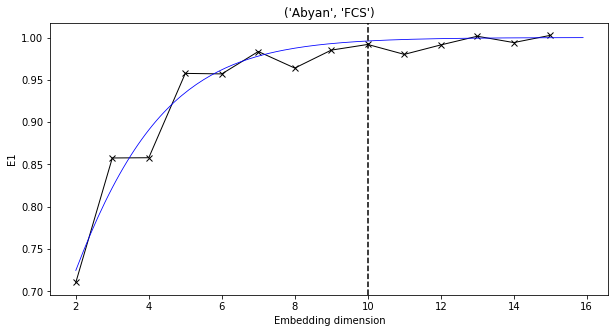

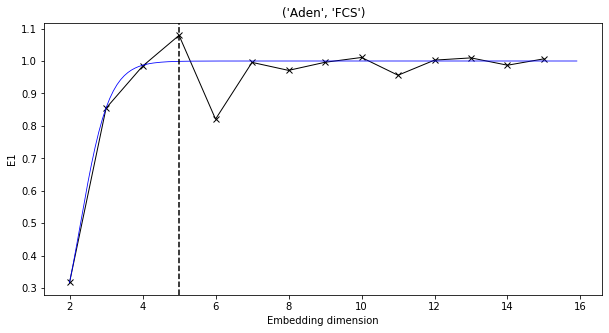

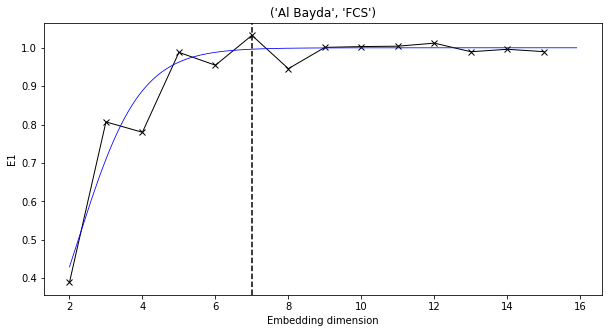

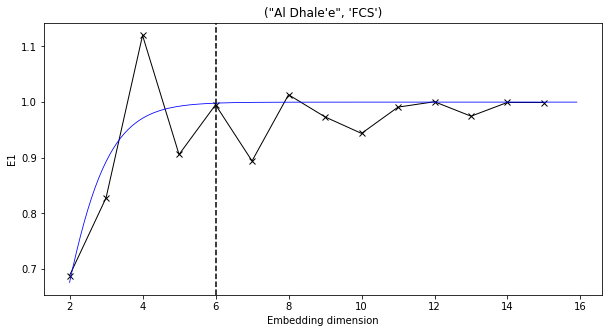

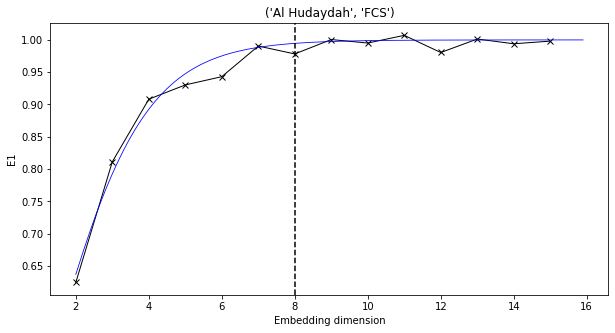

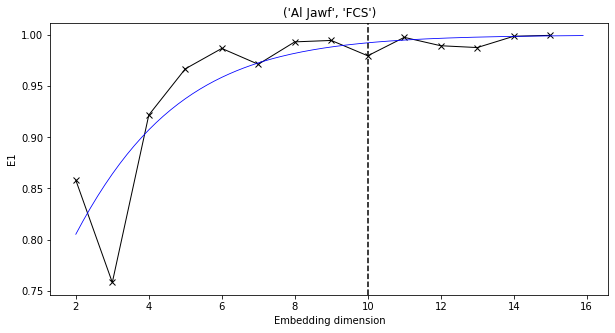

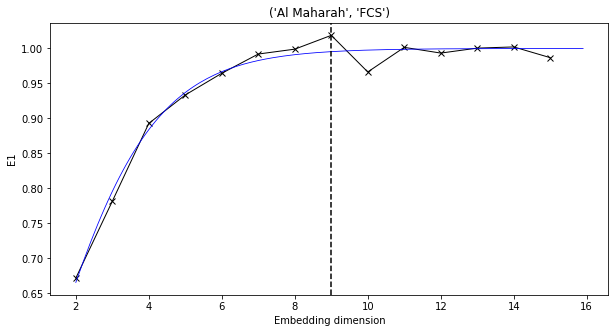

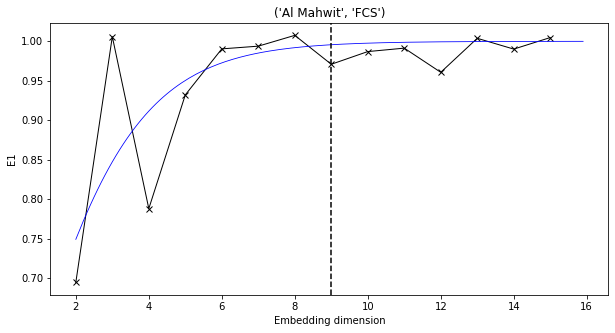

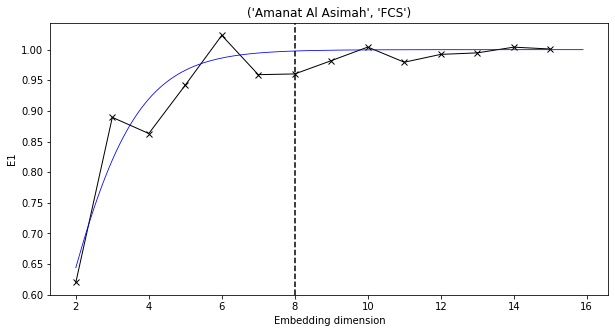

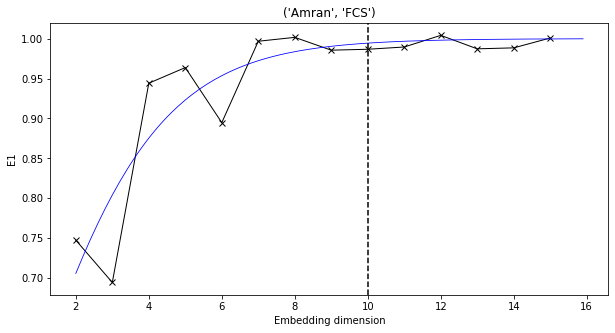

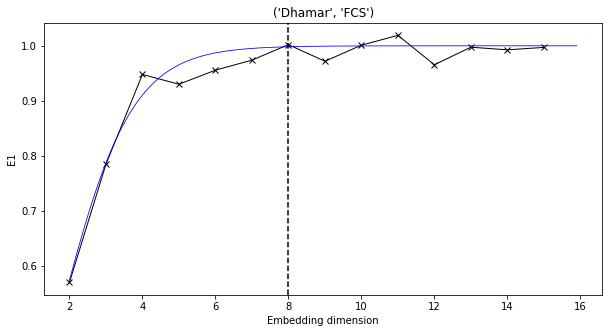

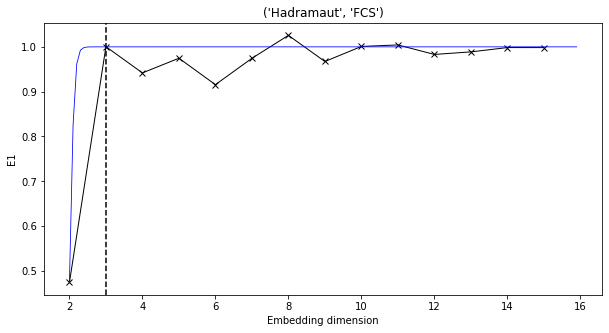

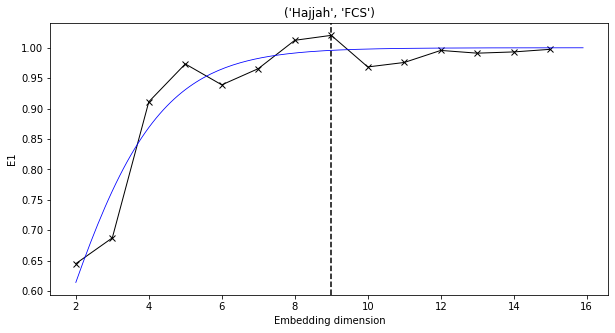

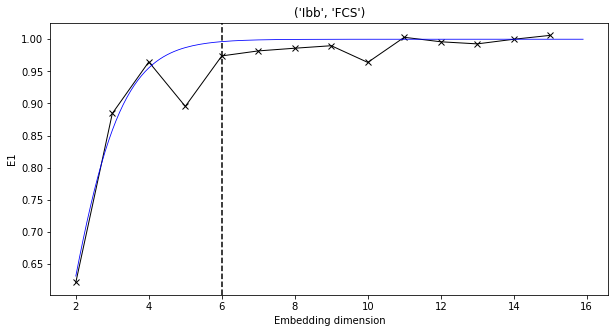

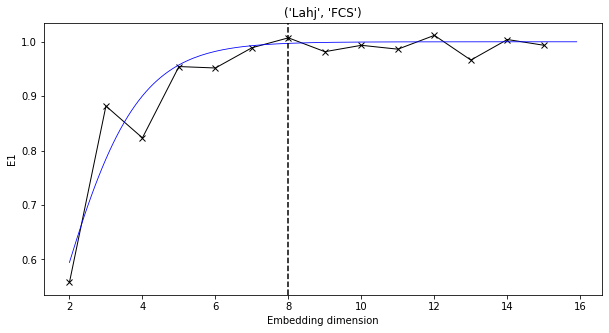

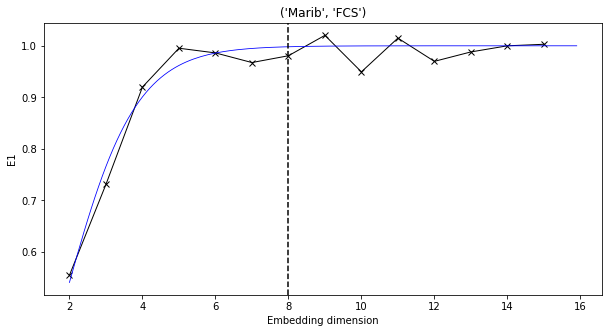

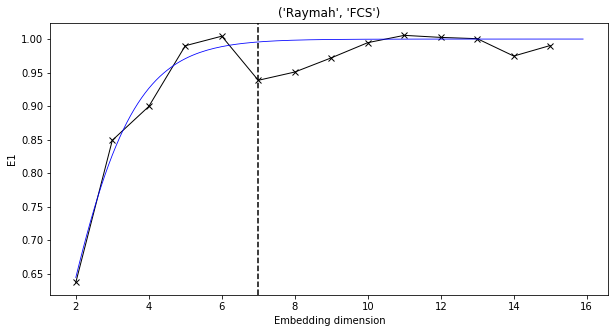

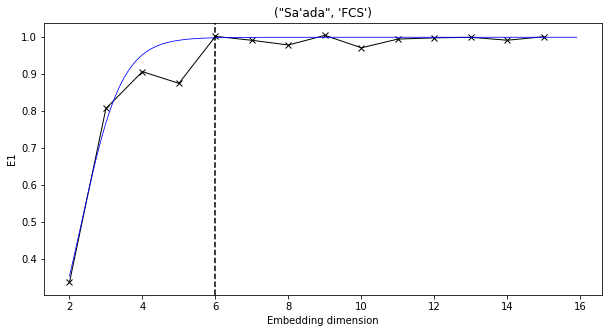

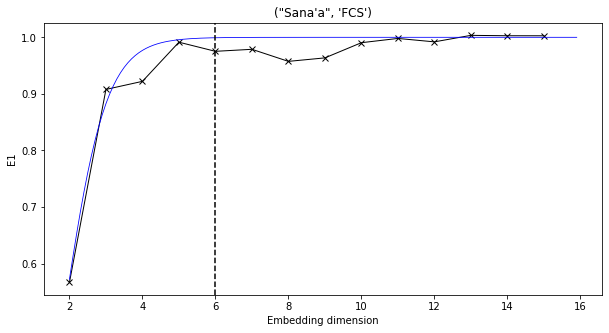

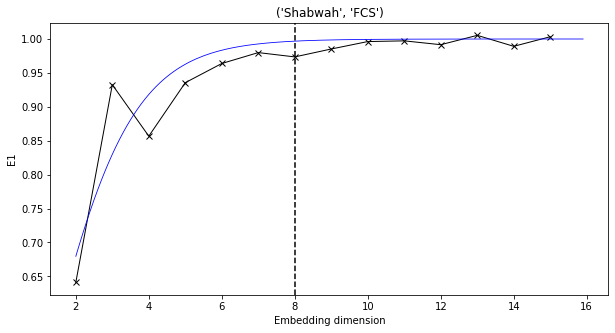

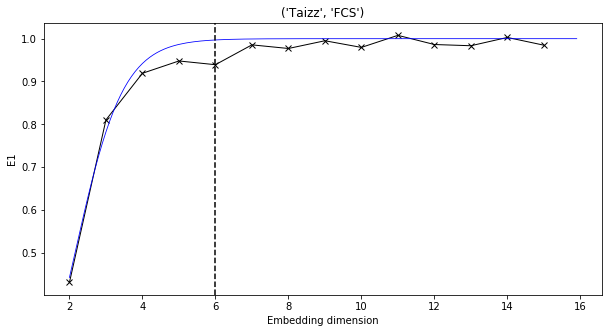

In [5]:
best_ms = fcs.apply(lambda serie: cao_algorithm(serie, 2, 15, plot = True))

In [7]:
best_ms

AdminStrata       Indicator
Abyan             FCS          10
Aden              FCS           5
Al Bayda          FCS           7
Al Dhale'e        FCS           6
Al Hudaydah       FCS           8
Al Jawf           FCS          10
Al Maharah        FCS           9
Al Mahwit         FCS           9
Amanat Al Asimah  FCS           8
Amran             FCS          10
Dhamar            FCS           8
Hadramaut         FCS           3
Hajjah            FCS           9
Ibb               FCS           6
Lahj              FCS           8
Marib             FCS           8
Raymah            FCS           7
Sa'ada            FCS           6
Sana'a            FCS           6
Shabwah           FCS           8
Taizz             FCS           6
dtype: int64

# Looking for the minimum embedding dimension $m$: Permutation entropy

For more detail see the paper and the notebook related to the paper "*On the predictability of infectious disease outbreaks*"[1].

[1]. "On the predictability of infectious disease outbreaks", Samuel V. Scarpino & Giovanni Petri.

In [8]:
import PermutationEntropy

In [9]:
ms = np.arange(2, 16)

In [12]:
tqdm.pandas()
best_ms = fcs.progress_apply(lambda serie: PermutationEntropy.search_best_m(serie, ms)).idxmin()

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.32s/it]


In [13]:
best_ms

AdminStrata       Indicator
Abyan             FCS          4
Aden              FCS          4
Al Bayda          FCS          4
Al Dhale'e        FCS          4
Al Hudaydah       FCS          4
Al Jawf           FCS          4
Al Maharah        FCS          4
Al Mahwit         FCS          4
Amanat Al Asimah  FCS          4
Amran             FCS          4
Dhamar            FCS          4
Hadramaut         FCS          4
Hajjah            FCS          4
Ibb               FCS          4
Lahj              FCS          4
Marib             FCS          4
Raymah            FCS          4
Sa'ada            FCS          4
Sana'a            FCS          4
Shabwah           FCS          4
Taizz             FCS          4
dtype: int64